In [1]:
'''
Imports all the necessary libraries
'''

%matplotlib inline
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn import linear_model
from sklearn import metrics
from sklearn.cross_validation import train_test_split

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
'''
Reads the data and removes duplicate patient entries.
The reason it is important to remove the duplicate entries is 
that one patient-sample has been tried against several antibiotics
'''
df = pd.read_csv('zevac_data.csv', sep='\t', usecols = ['patient_id', 'admission_id', 'age', 'sex', 'sc_date',
       'sample_type', 'bacteria_name', 'antibiotic_name', 'num_prev_adm',
       'interval', 'device', 'hai', 'susceptibility', 'comorbidity'])
blood=df[df['sample_type']=="Blood"]
sample_df=blood[['admission_id', 'patient_id', 'sc_date', 'bacteria_name']]
sample_df=sample_df.drop_duplicates()
gp = sample_df.groupby(['bacteria_name']).aggregate(np.count_nonzero)
tf = gp[gp.admission_id > 30].reset_index()
df=df[df['bacteria_name'].isin(tf.bacteria_name)]

df['sc_date']=df['sc_date'].apply(pd.Timestamp)
df['unique_id']=df['admission_id'].apply(str)+':'+df['patient_id'].apply(str)
df['unique_all']=df['admission_id'].apply(str)+':'+\
                    df['patient_id'].apply(str)+df['bacteria_name']+df['antibiotic_name']
df=df[df['sample_type']=='Blood']
df=df[df['sex']!='Others']
df=df[~df.duplicated('unique_id')]

In [12]:
'''
Preprocessing for regression
'''

df2=pd.get_dummies(df[['sex','device','comorbidity']])
df2=df2.drop(['sex_M','device_No Device','comorbidity_No Comorbidity'],axis=1)
regVars=df[['age','num_prev_adm','interval']]
regVars=pd.concat([df2,regVars],axis=1)
regVars['age 0-15']=regVars['age']<=15
regVars['age 31-60']=(regVars['age']>31)&(regVars['age']<=60)
regVars['age  >60']=(regVars['age']>60)&(regVars['age']<=200)
regVars['interval']=regVars['interval']/30 #Scaling Factor
regVars=regVars.drop('age',axis=1)

In [13]:
'''
For hyperparameter tuning, divide the data into train and test.
'''

y=df['bacteria_name']#.iloc[0:2400]
ty=df['bacteria_name'].iloc[2400:]
X=regVars#.iloc[0:2400]
tX=regVars.iloc[2400:]

In [14]:
mul_lr = linear_model.LogisticRegression(penalty='l2',random_state=12000,multi_class='multinomial', solver='newton-cg').fit(X, y)
mul_lr.coef_

array([[ 9.07003982e-02, -2.18226295e-03,  9.52101246e-01,
        -2.77910232e-02, -1.37846633e-01, -6.29847567e-02,
         1.73462817e-01, -3.99857565e-01,  2.11217694e-01,
        -6.13859205e-01, -2.33039113e-01, -1.63512161e-02,
        -5.87161027e-02,  5.69849304e-01, -6.63856141e-02,
         5.59450322e-01, -1.22972848e-01, -2.79692418e-02,
        -8.49884284e-03,  4.27475495e-01, -3.38170588e-01,
        -3.16421249e-02, -3.95562054e-02, -6.87082987e-01,
         1.59935420e+00, -4.56048661e-01, -7.42383627e-01],
       [ 2.43645467e-01, -4.79182508e-02, -7.65263026e-02,
        -3.92752860e-02,  6.39867355e-01,  8.41525618e-01,
        -4.88383580e-02, -4.73499262e-02, -3.83539983e-01,
         4.77038084e-02, -3.64914879e-02, -6.84561510e-03,
        -1.97835923e-01, -1.37860561e-01, -1.59366224e-02,
         4.00601887e-01, -7.05917645e-03,  5.23790868e-01,
        -1.25837361e-02, -2.12216019e-01,  1.45995624e-01,
        -6.93235521e-03,  6.58132102e-02,  9.52825653e-

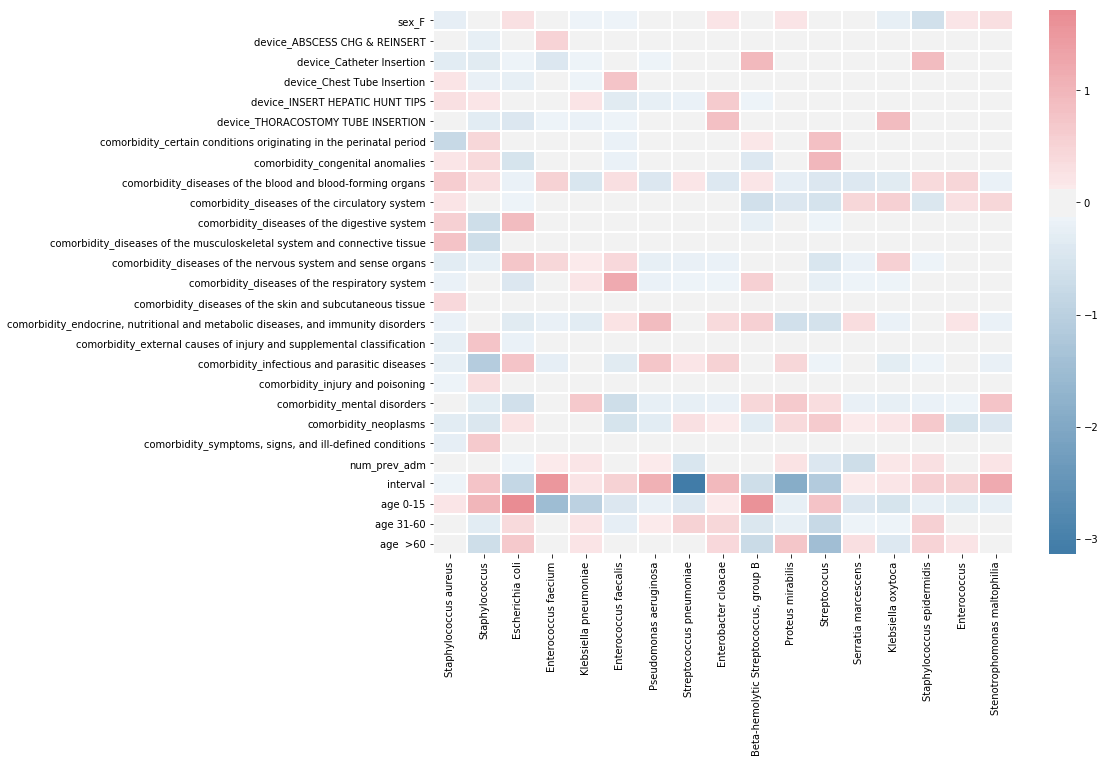

In [15]:
'''
Plotting the coefficients
'''
import matplotlib.pyplot as plt
import seaborn as sns

coef=pd.DataFrame(mul_lr.coef_,index=y.sort_values().unique(),columns=X.columns).transpose()
coef=coef[y.value_counts().index]
plt.figure(figsize=[13,10])
sns.heatmap(coef,cmap=sns.diverging_palette(240, 10, n=200),linewidths=1,center=0.0)

In [16]:
coef

,Staphylococcus aureus,Staphylococcus,Escherichia coli,Enterococcus faecium,Klebsiella pneumoniae,Enterococcus faecalis,Pseudomonas aeruginosa,Streptococcus pneumoniae,Enterobacter cloacae,"Beta-hemolytic Streptococcus, group B",Proteus mirabilis,Streptococus,Serratia marcescens,Klebsiella oxytoca,Staphylococcus epidermidis,Enterococcus,Stenotrophomonas maltophilia
sex_F,-0.258737,0.051617,0.284468,0.054554,-0.127329,-0.142896,-0.000863,0.101220,0.243645,0.090700,0.217496,-0.093499,-0.118536,-0.225321,-0.614546,0.200435,0.337591
device_ABSCESS CHG & REINSERT,-0.060084,-0.219889,-0.012415,0.518337,-0.031706,-0.031001,-0.074902,-0.000044,-0.047918,-0.002182,-0.000104,-0.000925,-0.005147,-0.005015,-0.006134,-0.006190,-0.014681
device_Catheter Insertion,-0.335287,-0.352411,-0.144166,-0.441649,-0.131791,-0.100558,-0.151004,-0.012125,-0.076526,0.952101,-0.044811,-0.006758,-0.011032,-0.021040,0.916024,-0.015525,-0.023443
device_Chest Tube Insertion,0.251586,-0.216056,-0.249563,-0.105067,-0.126481,0.759268,-0.059189,-0.031349,-0.039275,-0.027791,-0.032457,-0.021146,-0.039999,-0.019590,-0.021634,-0.014930,-0.006326
device_INSERT HEPATIC HUNT TIPS,0.287613,0.191533,0.044630,0.096034,0.236660,-0.352040,-0.240793,-0.165553,0.639867,-0.137847,-0.066846,-0.118588,-0.106776,-0.097466,-0.108351,-0.063232,-0.038845
device_THORACOSTOMY TUBE INSERTION,0.000177,-0.343450,-0.430062,-0.136010,-0.194719,-0.139106,-0.086133,-0.117874,0.841526,-0.062985,-0.065591,-0.056872,-0.058404,0.913239,-0.029513,-0.023216,-0.011007
comorbidity_certain conditions originating in the perinatal period,-0.786056,0.460625,-0.019596,-0.091671,-0.076073,-0.184728,-0.054542,-0.044605,-0.048838,0.173463,-0.020932,0.840734,-0.036889,-0.044626,-0.021474,-0.024159,-0.020631
comorbidity_congenital anomalies,0.187439,0.388738,-0.528886,-0.084660,-0.069702,-0.172775,-0.051440,-0.028729,-0.047350,-0.399858,-0.015831,0.959019,-0.033524,-0.040276,-0.018954,-0.023203,-0.020007
comorbidity_diseases of the blood and blood-forming organs,0.606909,0.315882,-0.173937,0.539622,-0.482510,0.317418,-0.428944,0.214827,-0.383540,0.211218,-0.274082,-0.410704,-0.369403,-0.365085,0.371520,0.490267,-0.179457
comorbidity_diseases of the circulatory system,0.252535,-0.026566,-0.130125,-0.008670,0.031807,0.073955,-0.041029,0.031215,0.047704,-0.613859,-0.408382,-0.544474,0.460532,0.566775,-0.450848,0.298148,0.461283


In [17]:
'''
Bootstrap to create the required number of readings
'''
readings=[]
for i in range(0,1000): #Number of bootstrap calculations
    if(i%10==0):
        print(i,end='-')
    Xdash=X.sample(n=len(X),replace=True)
    ydash=y.loc[Xdash.index]
    mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(Xdash, ydash)
    
    Coef=pd.DataFrame(mul_lr.coef_,columns=Xdash.columns,index=ydash.sort_values().unique()).transpose()
    readings+=[Coef]



0-10-20-30-40-50-60-70-80-90-100-110-120-130-140-150-160-170-180-190-200-210-220-230-240-250-260-270-280-290-300-310-320-330-340-350-360-370-380-390-400-410-420-430-440-450-460-470-480-490-500-510-520-530-540-550-560-570-580-590-600-610-620-630-640-650-660-670-680-690-700-710-720-730-740-750-760-770-780-790-800-810-820-830-840-850-860-870-880-890-900-910-920-930-940-950-960-970-980-990-

In [19]:
'''
Calculate the means and standerd deviations of the bootstrap so that we may use it for inference.
'''
import math
mean=readings[0].copy()
std=readings[0].copy()
def zero(inputS):
    return 0
mean=mean.apply(lambda x:x.apply(zero))
std=std.apply(lambda x:x.apply(zero))
for i in range(len(readings)):
    temp=readings[i].copy()
    mean=mean.add(temp,fill_value=0)
mean=mean/len(readings)
for i in range(len(readings)):    
    temp=readings[i].copy()
    temp=temp.add(-mean,fill_value=0)
    temp=temp*temp
    std=std.add(temp,fill_value=0)
std=std/len(readings)
std=std.apply(lambda x:x.apply(math.sqrt))

In [20]:
coef.index

Index(['sex_F', 'device_ABSCESS CHG & REINSERT', 'device_Catheter Insertion',
       'device_Chest Tube Insertion', 'device_INSERT HEPATIC HUNT TIPS',
       'device_THORACOSTOMY TUBE INSERTION',
       'comorbidity_certain conditions originating in the perinatal period',
       'comorbidity_congenital anomalies',
       'comorbidity_diseases of the blood and blood-forming organs',
       'comorbidity_diseases of the circulatory system',
       'comorbidity_diseases of the digestive system',
       'comorbidity_diseases of the musculoskeletal system and connective tissue',
       'comorbidity_diseases of the nervous system and sense organs',
       'comorbidity_diseases of the respiratory system',
       'comorbidity_diseases of the skin and subcutaneous tissue',
       'comorbidity_endocrine, nutritional and metabolic diseases, and immunity disorders',
       'comorbidity_external causes of injury and supplemental classification',
       'comorbidity_infectious and parasitic diseases'

In [21]:
'''
Rename the variables as required by the medical standards
'''
Indices=['Sex Female', 'Device: ABSCESS CHG & REINSERT', 'Device: Catheter Insertion',
       'Device: Chest Tube Insertion', 'Device: INSERT HEPATIC HUNT TIPS',
       'Device: THORACOSTOMY TUBE INSERTION',
       'Comorbidity: certain conditions originating in the perinatal period',
       'Comorbidity: congenital anomalies',
       'Comorbidity: diseases of the blood and blood-forming organs',
       'Comorbidity: diseases of the circulatory system',
       'Comorbidity: diseases of the digestive system',
       'Comorbidity: diseases of the musculoskeletal system and connective tissue',
       'Comorbidity: diseases of the nervous system and sense organs',
       'Comorbidity: diseases of the respiratory system',
       'Comorbidity: diseases of the skin and subcutaneous tissue',
       'Comorbidity: endocrine, nutritional and metabolic diseases, and immunity disorders',
       'Comorbidity: external causes of injury and supplemental classification',
       'Comorbidity: infectious and parasitic diseases',
       'Comorbidity: injury and poisoning', 'Comorbidity: mental disorders',
       'Comorbidity: neoplasms',
       'Comorbidity: symptoms, signs, and ill-defined conditions',
       '# Previous Admissions', 'Interval', 'Age: 0-15', 'Age: 31-60', 'Age:  >60']

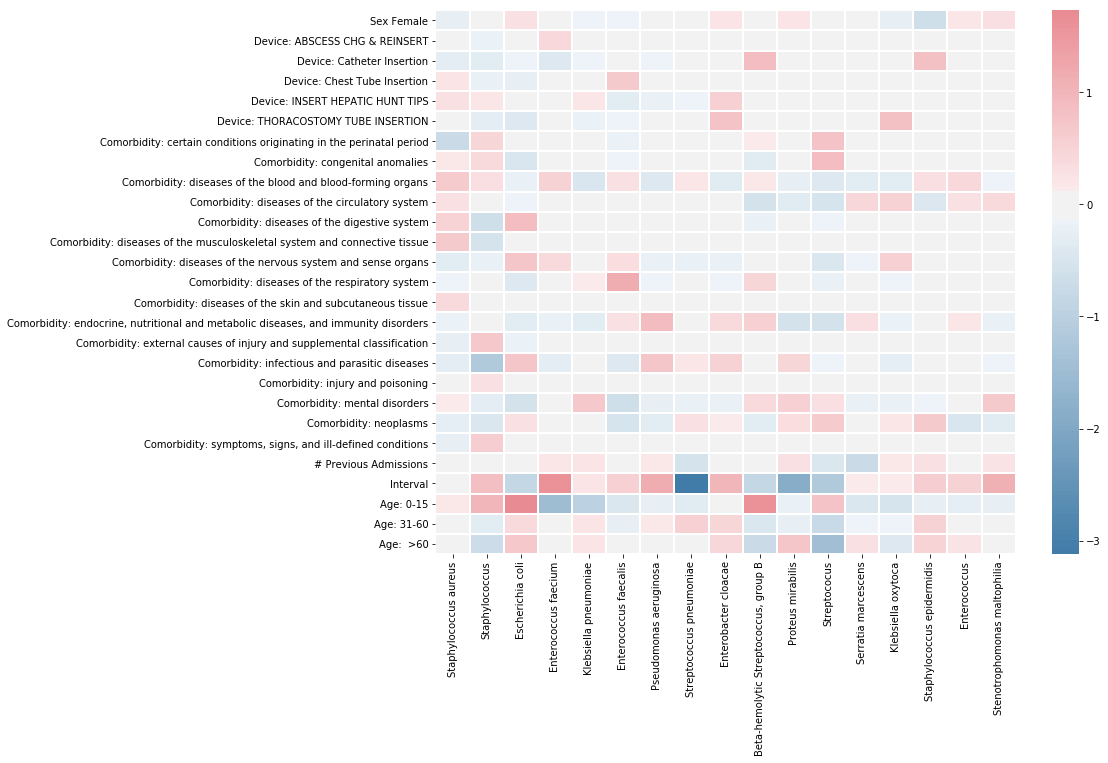

In [22]:
'''
Look at the intermediate plot of mean (or standard deviation)
'''

plt.figure(figsize=[13,10])
temp=mean#-2*std#.apply(lambda x:x.apply(lambda x:math.e**x))
temp=temp[y.value_counts().index]
temp.index=Indices
sns.heatmap(temp,cmap=sns.diverging_palette(240, 10, n=200),linewidths=1,center=0.0)

In [23]:
'''
The largest and the smallest coefficients.
'''
temp.stack().sort_values(ascending=False)

Age: 0-15                                                                           Escherichia coli                         1.729450
Interval                                                                            Enterococcus faecium                     1.612481
Age: 0-15                                                                           Beta-hemolytic Streptococcus, group B    1.598715
Comorbidity: diseases of the respiratory system                                     Enterococcus faecalis                    1.180012
Interval                                                                            Pseudomonas aeruginosa                   1.147066
                                                                                    Stenotrophomonas maltophilia             1.120421
Age: 0-15                                                                           Staphylococcus                           1.006083
Interval                                                      

In [24]:
'''
Use mean and standard deviation to calculate the lower and upper bound so that one can use it for inference.
'''
lower=mean-2*std
upper=mean+2*std
mean2=mean.stack().copy()
lower=lower.apply(lambda x:(x-abs(x))/2)
lower=lower.stack()
upper=upper.apply(lambda x:(abs(x)-x)/2)
upper=upper.stack()
mean2[(mean2>0) & (lower <0)]=0
mean2[(mean2<0) & (upper >0)]=0

In [25]:
mean2=mean2.unstack()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 <a list of 17 Text xticklabel objects>)

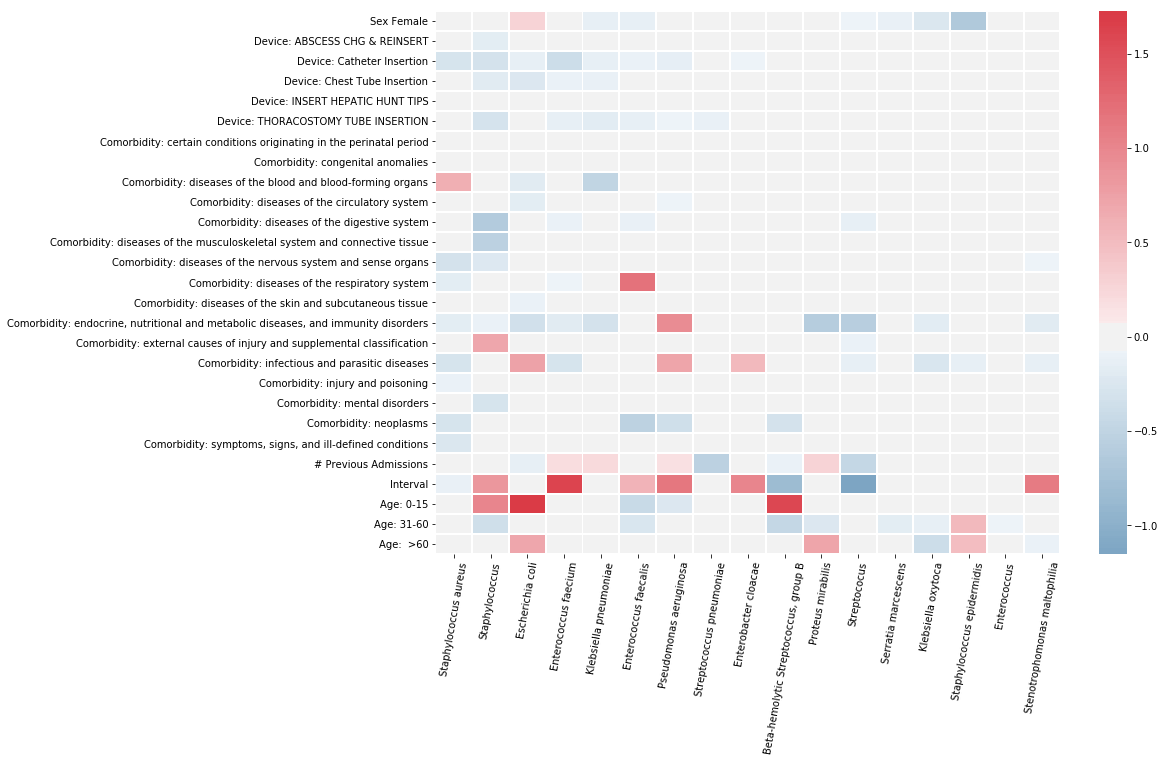

In [34]:
plt.figure(figsize=[14,10])
temp=mean2#-2*std#.apply(lambda x:x.apply(lambda x:math.e**x))
temp=temp[y.value_counts().index]
temp.index=Indices
sns.heatmap(temp,cmap=sns.diverging_palette(240, 10, n=200),linewidths=1,center=0.0)
plt.xticks(rotation=80)

In [27]:
temp2=temp.unstack().sort_values(ascending=False)#.to_clipboard()

In [28]:
temp2=pd.DataFrame(temp2)
temp2['multiplyingFactor']=temp2.apply(lambda x:math.e**x)

In [29]:
temp2

,,0,multiplyingFactor
Escherichia coli,Age: 0-15,1.729450,5.637554
Enterococcus faecium,Interval,1.612481,5.015238
"Beta-hemolytic Streptococcus, group B",Age: 0-15,1.598715,4.946674
Enterococcus faecalis,Comorbidity: diseases of the respiratory system,1.180012,3.254412
Pseudomonas aeruginosa,Interval,1.147066,3.148939
Stenotrophomonas maltophilia,Interval,1.120421,3.066144
Staphylococcus,Age: 0-15,1.006083,2.734867
Enterobacter cloacae,Interval,0.999413,2.716686
Pseudomonas aeruginosa,"Comorbidity: endocrine, nutritional and metabolic diseases, and immunity disorders",0.932740,2.541464
Staphylococcus,Interval,0.846249,2.330887
